## Homework: Introduction

In this homework, we'll learn more about search and use Elastic Search for practice.

## Q1. Running Elastic



Run Elastic Search 8.17.6, and get the cluster information. If you run it on localhost, this is how you do it:


```bash
curl localhost:9200
```

What's the version.build_hash value?



### Answer:
- dbcbbbd0bc4924cfeb28929dc05d82d662c527b7

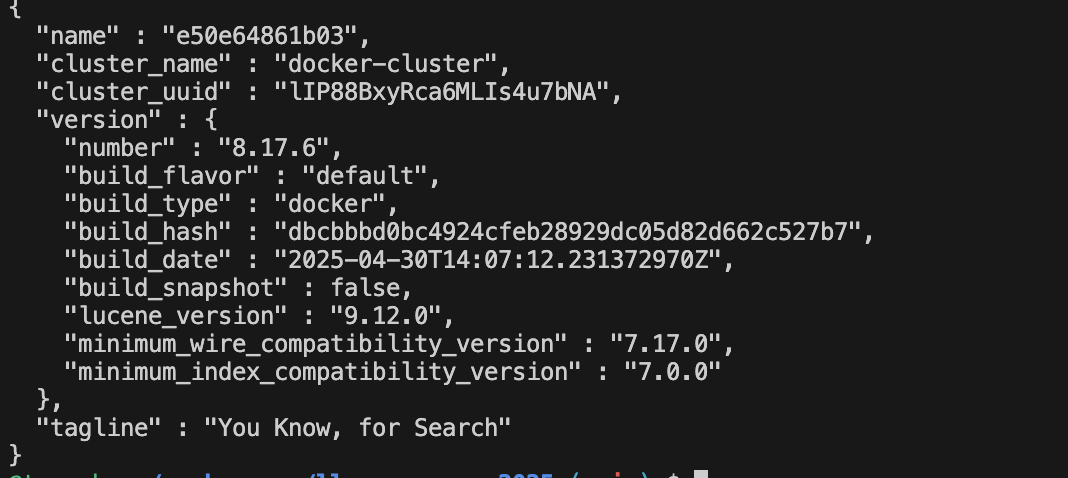

## Getting the data


Now let's get the FAQ data. You can run this snippet:



In [15]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

Note that you need to have the requests library:
- pip install requests



In [16]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

## Q2. Indexing the data



Index the data in the same way as was shown in the course videos. Make the course field a keyword and the rest should be text.

Which function do you use for adding your data to elastic?

- insert
- index
- put
- add

In [19]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

In [ ]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"}
        }
    }
}

index_name = "course-questions"

es_client.indices.create(index=index_name, body=index_settings)


In [20]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

#### Index our data

In [7]:
from tqdm.auto import tqdm

In [8]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

### Answer:
- index

## Q3. Searching

Now let's search in our index.

We will execute a query "How do execute a command on a Kubernetes pod?".

Use only **question** and **text** fields and give **question** a boost of 4, and use **"type": "best_fields"**.

What's the score for the top ranking result?

- 94.05
- 84.05
- 74.05
- 64.05

Look at the **_score** field.


In [21]:
query = "How do execute a command on a Kubernetes pod?"

In [25]:
query

'How do execute a command on a Kubernetes pod?'

In [22]:
search_query = {
    "size": 5,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            },
        }
    }
}

response = es_client.search(index=index_name, body=search_query)

In [23]:
answers = []

for i in response['hits']['hits']:
    answers.append(i['_source'])

In [24]:
response['hits']['hits']

[{'_index': 'course-questions',
  '_id': 'Nq0gb5cBrBvpeI3tz2UZ',
  '_score': 44.50556,
  '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)',
   'section': '5. Deploying Machine Learning Models',
   'question': 'How do I debug a docker container?',
   'course': 'machine-learning-zoomcamp'}},
 {'_index': 'course-questions',
  '_id': 'xa0gb5cBrBvpeI3t0WUM',
  '_score': 35.433445,
  '_source': {'text': 'Deploy and Access the Kubernetes Dashboard\nLuke',
   'section': '10. Kubernetes and TensorFlow Serving',
   'question': 'Kubernetes-dashboard',
   'course': 'machine-learning-zoomcamp'}},
 {'_index': 'course-questions',
  '_id': 'Vq0gb5cBrBvpeI3tz2WL',
  '_score': 33.70974,
  '_source': {'text': 'You 

### Answer:
- 44.50

## Q4. Filtering
Now ask a different question: "How do copy a file to a Docker container?".

This time we are only interested in questions from machine-learning-zoomcamp.

Return 3 results. What's the 3rd question returned by the search engine?

- How do I debug a docker container?
- How do I copy files from a different folder into docker container’s working directory?
- How do Lambda container images work?
- How can I annotate a graph?

In [25]:
query = "How do copy a file to a Docker container?"

In [26]:
search_query = {
    "size": 3,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course":"machine-learning-zoomcamp"
                }}
        }
    }
}

response = es_client.search(index=index_name, body=search_query)

In [27]:
response['hits']['hits']

[{'_index': 'course-questions',
  '_id': 'Nq0gb5cBrBvpeI3tz2UZ',
  '_score': 73.38676,
  '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)',
   'section': '5. Deploying Machine Learning Models',
   'question': 'How do I debug a docker container?',
   'course': 'machine-learning-zoomcamp'}},
 {'_index': 'course-questions',
  '_id': 'Va0gb5cBrBvpeI3tz2WC',
  '_score': 66.688705,
  '_source': {'text': "You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_

In [28]:
answers = []

for i in response['hits']['hits']:
    answers.append(i['_source'])

### Answer: 
- How do I copy files from a different folder into docker container’s working directory?

## Q5. Building a prompt
Now we're ready to build a prompt to send to an LLM.

Take the records returned from Elasticsearch in Q4 and use this template to build the context. Separate context entries by two linebreaks (\n\n)

In [31]:
context_template = """
Q: {question}
A: {text}
""".strip()

Now use the context you just created along with the "How do copy a file to a Docker container?" question to construct a prompt using the template below

In [32]:
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

### What's the length of the resulting prompt? (use the len function)

- 962
- 1462
- 1962
- 2462

#### Make a context

In [46]:
context = ''

for doc in answers:
    context = context + f'Q: {doc['question']}\nA: {doc['text']}\n\n'

In [47]:
print(context)

Q: How do I debug a docker container?
A: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.
docker run -it --entrypoint bash <image>
If the container is already running, execute a command in the specific container:
docker ps (find the container-id)
docker exec -it <container-id> bash
(Marcos MJD)

Q: How do I copy files from my local machine to docker container?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:
To copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:
docker cp /path/to/local/file_or_directory container_id:/path/in/container
Hrithik Kumar Advani

Q: How do I copy files from a different folder into docker container’s working directory?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to 

#### Make a promt

In [50]:
prompt = prompt_template.format(question = query, context = context).strip()

prompt

'You\'re a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.\nUse only the facts from the CONTEXT when answering the QUESTION.\n\nQUESTION: How do copy a file to a Docker container?\n\nCONTEXT:\nQ: How do I debug a docker container?\nA: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)\n\nQ: How do I copy files from my local machine to docker container?\nA: You can copy files from your local machine into a Docker container using the docker cp command. Here\'s how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container

In [51]:
print(prompt)

You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: How do copy a file to a Docker container?

CONTEXT:
Q: How do I debug a docker container?
A: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.
docker run -it --entrypoint bash <image>
If the container is already running, execute a command in the specific container:
docker ps (find the container-id)
docker exec -it <container-id> bash
(Marcos MJD)

Q: How do I copy files from my local machine to docker container?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:
To copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:
docker cp /path/to/local/file_or_directory container_id:/path/in/contain

In [52]:
len(prompt)

1446

### Answer:
- 1446

## Q6. Tokens
When we use the OpenAI Platform, we're charged by the number of tokens we send in our prompt and receive in the response.

The OpenAI python package uses tiktoken for tokenization:

In [53]:
pip install tiktoken

  Obtaining dependency information for tiktoken from https://files.pythonhosted.org/packages/1b/40/da42522018ca496432ffd02793c3a72a739ac04c3794a4914570c9bb2925/tiktoken-0.9.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for regex>=2022.1.18 from https://files.pythonhosted.org/packages/fb/13/e3b075031a738c9598c51cfbc4c7879e26729c53aa9cca59211c44235314/regex-2024.11.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 66.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
import tiktoken

Let's calculate the number of tokens in our query:


In [56]:
encoding = tiktoken.encoding_for_model("gpt-4o")

Use the encode function. How many tokens does our prompt have?

- 120
- 220
- 320
- 420

In [61]:
tokens = encoding.encode(prompt)

num_tokens = len(tokens)

num_tokens

320

### Answer:
- 320